In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import time
import copy
from scipy.signal import find_peaks, resample
from icecream import ic
from collections import OrderedDict

from neurolib.models.aln import ALNModel
#from neurolib.models.aln import ALNModel_SaveSteps
import neurolib.utils.stimulus as stim
import neurolib.utils.functions as func  
from neurolib.utils.parameterSpace import ParameterSpace
from neurolib.optimize.exploration import BoxSearch
import os
import sys
from pynverse import inversefunc

from intersect import intersection
from scipy.stats import mode


sys.path.insert(0, '..')
from prc_funcs import *
from functions import *
    

import matplotlib.colors as mcolors

colors = mcolors.TABLEAU_COLORS
by_hsv = sorted((tuple(mcolors.rgb_to_hsv(mcolors.to_rgb(color))),
                         name)
                        for name, color in colors.items())
colrs = [name for hsv, name in by_hsv]

#hide
import logging
logging.getLogger().setLevel(logging.INFO)
import warnings
warnings.filterwarnings("ignore")

BASE_PATH = "../../../../" # need to go back from default hdf path "./data/hdf"
HDF_PATH = BASE_PATH + "Data/"


## Pic of min and max periods of two-node system given from simulation and PRC-prediction

### 1. Create and Store PRCs of ALN with real rate input for multiple coupling strengths
$K_{E, gl}$ =
* 20
* 40
* 60
* 80
* 100 
* 120
* 140
* 160
* 180 
* 200 
* 220 
* ...

In [2]:
sampling = 1
aln = ALNModel()
aln.params['mue_ext_mean'] = 1.1
aln.params['mui_ext_mean'] = 0.5
aln.params['dt'] = 0.01
aln.params['sampling_dt'] = aln.params.dt * sampling
aln.params['a'] = 0.
aln.params['b'] = 0.
aln.params['sigma_ou'] = 0.
#aln.params['Ke_gl'] = 30.
prc = PRC_ALN(aln)

INFO:root:aln: Model initialized.
ic| domfreq: 21.50526315789473


initialised ...


In [3]:
#kes =  np.arange(20, 240, 20)
kes = np.asarray([1, 10, 240, 260, 280, 300])

In [25]:
#for ke in kes:
#    prc.calc_prc_xcorr(
#        itype="real", 
#        Ke_gl=ke, 
#        num_points=100
#    )
#    np.save("../data/PRC_real_Kegl={0:.0f}_lowres.npy".format(ke), prc.prc_xcorr) 
    #prc_xcorr = np.load('../data/PRC_real_Kegl=50_highres.npy',allow_pickle='TRUE').item()

100%|██████████| 100/100 [01:54<00:00,  1.14s/it]


In [4]:
kes_all = np.sort(np.hstack((np.arange(20, 240, 20), np.asarray([1, 10, 240, 260, 280, 300]))))

Prcmin = {}
Prcmax = {}
for ke in kes_all:
    Prc = np.load("data/PRC_real_Kegl={0:.0f}_lowres.npy".format(ke),allow_pickle='TRUE').item()
    minp = np.min(list(Prc.values()))
    maxp = np.max(list(Prc.values()))
    Prcmin[ke] = minp
    Prcmax[ke] = maxp

In [5]:
fig, ax = plt.subplots(dpi=200)
ax.plot(list(Prcmin.values()), list(Prcmin.keys()), c="tab:orange", lw=3)
ax.plot(list(Prcmax.values()), list(Prcmax.keys()), c="tab:orange", lw=3)

ax.set_xlabel("phase response extrema [ms]")
ax.set_ylabel("Kegl")

Text(0, 0.5, 'Kegl')

In [6]:
fig, ax = plt.subplots(dpi=200)
ax.plot(list(Prcmin.values())/prc.frperiod, list(Prcmin.keys()), c="tab:orange", lw=3)
ax.plot(list(Prcmax.values())/prc.frperiod, list(Prcmax.keys()), c="tab:orange", lw=3)

ax.set_xlabel("phase response extrema [ms]")
ax.set_ylabel("Kegl")
ax.grid()

In [7]:
fig, ax = plt.subplots(dpi=200)
ax.plot(1 - np.asarray(list(Prcmin.values()))/prc.frperiod, list(Prcmin.keys()), c="tab:orange", lw=3)
ax.plot(1 - np.asarray(list(Prcmax.values()))/prc.frperiod, list(Prcmax.keys()), c="tab:orange", lw=3)

ax.set_xlabel(r"T / $T_{fr}$")
ax.set_ylabel(r"$K_{E,gl}$")
ax.grid()

## 2. simulate two-node model for some delay values and store frequency

In [8]:
def get_all_stim_freqs(delay):
    ''' System Frequency is function of delay can be approximated in two ways
    1. (synchroinzation_state + 1) x Period + 50 = 2 x delay 
    2. synchroniation_state x Period = 2 * delay 
    The second is a little worse but fits better to my theory.'''
    def method_one(state, sys_delay):
        period = (sys_delay+50) / (state+1)  
        return 1000 / period
    
    def method_two(state, sys_delay):
        if state == 0:
            period = sys_delay / (state+1)
        else:
            period = sys_delay / state
        period += 1
        return 1000 / period 

    ret = []
    for i in range(3):
        if i % 2 == 0:
            ret.append(('in', method_one(state = i, sys_delay= 2 * delay)))
        else:
            ret.append(('anti', method_one(state = i, sys_delay= 2 * delay)))
    
    return ret

In [9]:
SP_WINDOW = 100

def evalf(traj):
    pars = search.getParametersFromTraj(traj)
    aln.params['Ke_gl'] = pars['Ke_gl']
    aln.params['signalV'] = pars['signalV']
    
    # calc absolute interareal delay
    delay = aln.params.lengthMat[0,1] / aln.params.signalV
    
    sfreqs = get_all_stim_freqs(delay)
    freqs = np.ndarray((len(sfreqs)))
    shifts = np.ndarray((len(sfreqs)))
    
    for i, sfreq in enumerate(sfreqs):
        stim_type = sfreq[0]
        stim_freq = sfreq[1]
        
        if stim_type == 'anti':
            stimulus = construct_antiphase_stimulus(stim_bias = 0, 
                                       duration = aln.params.duration, 
                                       dt = aln.params.dt, 
                                       stim_freq_anti = int(stim_freq), 
                                       n_periods_anti = int(2*stim_freq),
                                       stim_amp = 0.4, 
                                       nostim_before = 0,
                                       nostim_after = aln.params.duration,
                                       decay=True)
        elif stim_type == 'in':
            stimulus = construct_inphase_stimulus(stim_bias = 0, 
                                       duration = aln.params.duration, 
                                       dt = aln.params.dt, 
                                       stim_freq_in = int(stim_freq), 
                                       n_periods_in = int(2*stim_freq),
                                       stim_amp = 0.4, 
                                       nostim_before = 0,
                                       nostim_after = aln.params.duration,
                                       decay=True)
        else:
            print("Stim type not defined:")
            results_dict = {}
            search.saveOutputsToPypet(result_dict, traj)
            return
        
        aln.params['ext_exc_current'] = stimulus
        aln.randomICs()
        aln.run()
        
        # Evaluation
        stage = aln['rates_exc'][:, int(5000/aln.params.dt) :]
        stim_shift = phase_shift(stage[0], stage[1], duration=10000, dt=aln.params.dt)
        domfreq = dom_frequency(stage[0],
                            dt=aln.params['dt'],
                            SP_WINDOW=SP_WINDOW)
        
        shifts[i] = stim_shift[0] # stim_shift in [0,1]
        freqs[i] = domfreq
        
        
        
    result_dict = {"delay" : delay, 
                   #"sfreq" : sfreqs[1],
                   "shifts" : shifts,
                   "frequencies" : freqs}   
        
    search.saveToPypet(result_dict, traj)
    return

In [10]:
Cmat = np.ones((2,2))
np.fill_diagonal(Cmat, 0)
Dmat = Cmat.copy()
Dmat *= 50 

aln = ALNModel(Cmat = Cmat, Dmat = Dmat)
# Put ALN in "A3" Point right inside the LC_EI
aln.params['mue_ext_mean'] = 1.1
aln.params['mui_ext_mean'] = 0.5

# no adaptation 
aln.params['a'] = 0.
aln.params['b'] = 0. 

aln.params['sigma_ou'] = 0.

aln.params['dt'] = 0.01

aln.params['duration'] = 30 * 1000 

INFO:root:aln: Model initialized.


In [11]:
def delayToVelocity(delay, distance=50):
    '''delay in my, distance in mm'''
    return distance / delay

delay = np.arange(0, 30, 0.5)
Ke = np.hstack((np.asarray([1]),np.arange(30, 400, 30)))

signalV = delayToVelocity(delay)


parameters = ParameterSpace({"signalV": signalV,
                             "Ke_gl": Ke})

#parameters = ParameterSpace({"signalV": [1],
#                             "Ke_gl": [1]})

search = BoxSearch(evalFunction = evalf,
                   parameterSpace=parameters,
                   filename=HDF_PATH+'TwoNode_Freq_range_with_Ke.hdf',
                   ncores=8)

INFO:root:Number of processes: 8
MainProcess pypet.storageservice.HDF5StorageService INFO     I will use the hdf5 file `./data/hdf/../../../../Data/TwoNode_Freq_range_with_Ke.hdf`.
MainProcess pypet.environment.Environment INFO     Environment initialized.
MainProcess root INFO     Number of parameter configurations: 840
MainProcess root INFO     BoxSearch: Environment initialized.


In [12]:
#search.run()

In [13]:
search.loadResults(all=False)

MainProcess root INFO     Loading results from ./data/hdf/../../../../Data/TwoNode_Freq_range_with_Ke.hdf
MainProcess root INFO     Analyzing trajectory results-2021-12-13-13H-48M-41S
MainProcess pypet.storageservice.HDF5StorageService INFO     I will use the hdf5 file `./data/hdf/../../../../Data/TwoNode_Freq_range_with_Ke.hdf`.
MainProcess pypet.storageservice.HDF5StorageService INFO     Loading trajectory `results-2021-12-13-13H-48M-41S`.
MainProcess pypet.storageservice.HDF5StorageService INFO     Loading branch `config` in mode `2`.
MainProcess pypet.storageservice.HDF5StorageService INFO     Loading branch `parameters` in mode `2`.
MainProcess pypet.storageservice.HDF5StorageService INFO     Loading branch `results` in mode `1`.
MainProcess root INFO     Creating `dfResults` dataframe ...
MainProcess root INFO     Aggregating results to `dfResults` ...
100%|██████████| 840/840 [00:07<00:00, 116.34it/s]
MainProcess root INFO     All results loaded.


In [14]:
Kes = search.dfResults.Ke_gl.drop_duplicates()
sim_min = {}
sim_max = {}
for Ke in Kes:
    df = search.dfResults[search.dfResults.Ke_gl == Ke]
    minf = []
    maxf = []
    for i in df.index:
        minf.append(np.min(df.frequencies[i]))
        maxf.append(np.max(df.frequencies[i]))
    minfreq = np.min(minf)
    maxfreq = np.max(maxf)
    sim_max[Ke] = 1000 / minfreq
    sim_min[Ke] = 1000 / maxfreq

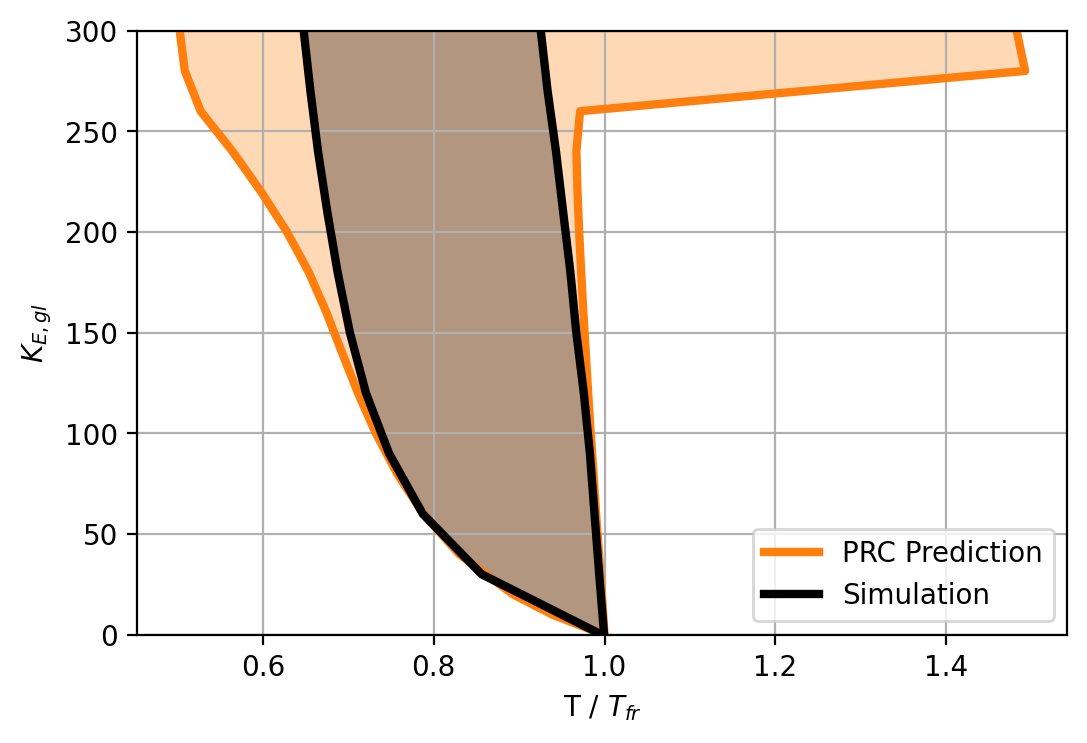

In [15]:
fig, ax = plt.subplots(dpi=200)
ax.plot(1 - np.asarray(list(Prcmin.values()))/prc.frperiod, list(Prcmin.keys()), c="tab:orange", lw=3)
ax.plot(1 - np.asarray(list(Prcmax.values()))/prc.frperiod, list(Prcmax.keys()), c="tab:orange", lw=3, label="PRC Prediction")

ax.fill_betweenx(list(Prcmin.keys()), 1 - np.asarray(list(Prcmin.values()))/prc.frperiod, 1 - np.asarray(list(Prcmax.values()))/prc.frperiod, color="tab:orange", alpha=0.3)


ax.plot(np.asarray(list(sim_min.values()))/prc.frperiod, list(sim_min.keys()), c="black", lw=3)
ax.plot(np.asarray(list(sim_max.values()))/prc.frperiod, list(sim_max.keys()), c="black", lw=3, label="Simulation")

ax.fill_betweenx(list(sim_min.keys()), np.asarray(list(sim_min.values()))/prc.frperiod, np.asarray(list(sim_max.values()))/prc.frperiod, color="black", alpha=0.3)

ax.set_ylim(0, 300)
ax.set_xlabel(r"T / $T_{fr}$")
ax.set_ylabel(r"$K_{E,gl}$")
ax.grid()
ax.legend()

# now with my style

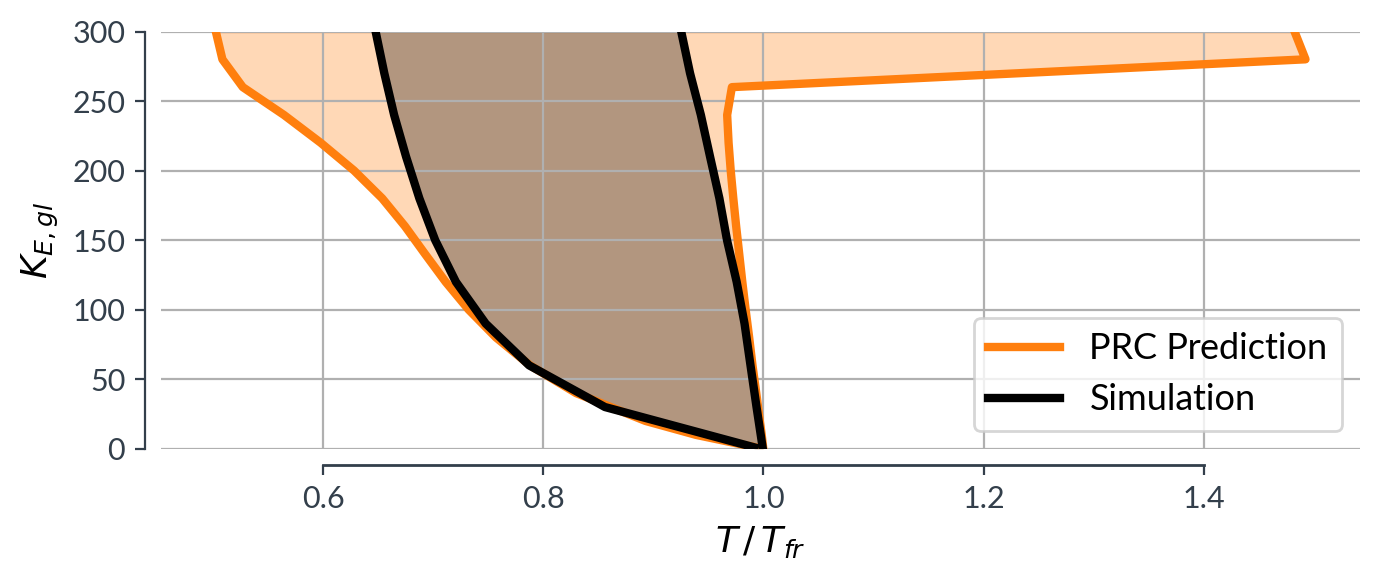

In [16]:
plt.rcParams['font.family'] = 'Lato'
plt.rcParams['font.sans-serif'] = 'Lato'
plt.rcParams['axes.edgecolor']='#333F4B'
plt.rcParams['axes.linewidth']=0.8
plt.rcParams['xtick.color']='#333F4B'
plt.rcParams['ytick.color']='#333F4B'
plt.rcParams['axes.labelsize']=13
plt.rcParams['xtick.labelsize']=11
plt.rcParams['ytick.labelsize']=11
plt.rcParams['legend.fontsize'] = 13

fig, ax = plt.subplots(figsize=(7, 3), dpi=200)

ax.plot(1 - np.asarray(list(Prcmin.values()))/prc.frperiod, list(Prcmin.keys()), c="tab:orange", lw=3)
ax.plot(1 - np.asarray(list(Prcmax.values()))/prc.frperiod, list(Prcmax.keys()), c="tab:orange", lw=3, label="PRC Prediction")

ax.fill_betweenx(list(Prcmin.keys()), 1 - np.asarray(list(Prcmin.values()))/prc.frperiod, 1 - np.asarray(list(Prcmax.values()))/prc.frperiod, color="tab:orange", alpha=0.3)


ax.plot(np.asarray(list(sim_min.values()))/prc.frperiod, list(sim_min.keys()), c="black", lw=3)
ax.plot(np.asarray(list(sim_max.values()))/prc.frperiod, list(sim_max.keys()), c="black", lw=3, label="Simulation")

ax.fill_betweenx(list(sim_min.keys()), np.asarray(list(sim_min.values()))/prc.frperiod, np.asarray(list(sim_max.values()))/prc.frperiod, color="black", alpha=0.3)

ax.set_ylim(0, 300)
ax.set_xlabel(r"$T\, / \,T_{fr}$")
ax.set_ylabel(r"$K_{E,gl}$")
ax.grid()
ax.legend()
 
#ax.set_xticklabels(['0.6','0.8', '1.0', '1.2', '1.4', '1.6'])


ax.tick_params(right=False, top=False)

ax.spines["top"].set_visible(False), ax.spines["right"].set_visible(False)

plt.draw()

lab = [float(item.get_text().replace("−", "-")) for item in ax.get_yticklabels(which='both')]
ax.spines["left"].set_bounds(low=min(lab), high=max(lab))
ax.spines["left"].set_position(("outward", 6))

ax.spines["bottom"].set_bounds(low=0.6, high=1.4)
ax.spines["bottom"].set_linewidth(1)
ax.spines["bottom"].set_position(("outward",6))
fig.tight_layout()
#fig.savefig("Pics/Period_Range_with_Ke.pdf")

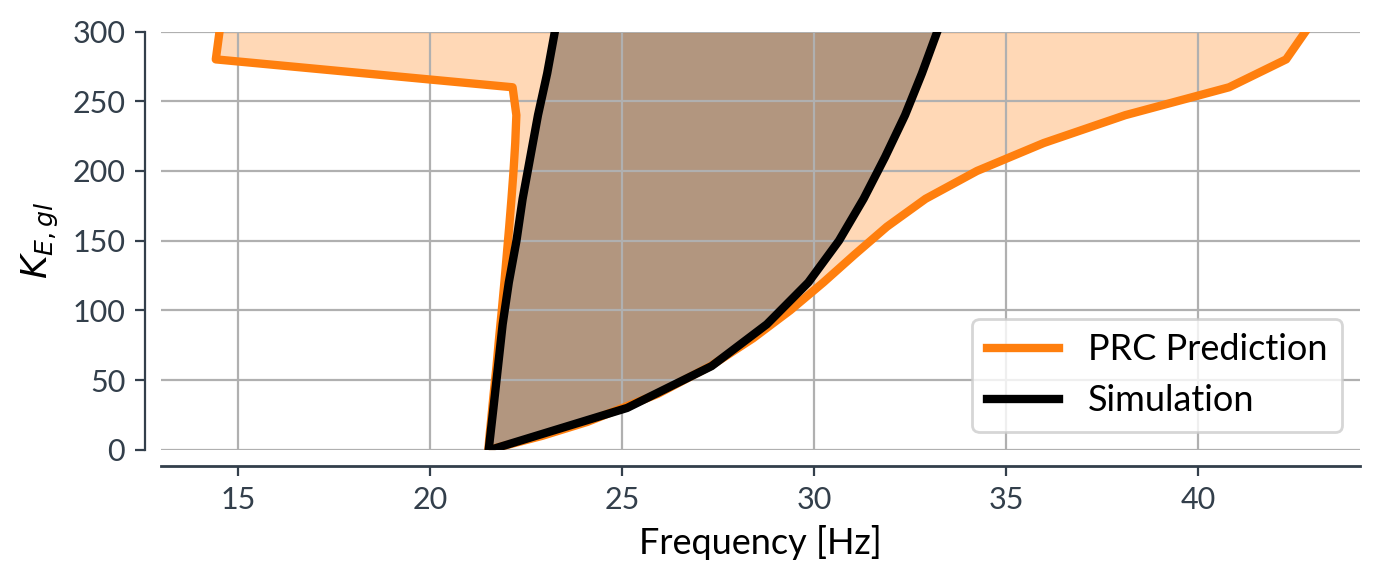

In [119]:
plt.rcParams['font.family'] = 'Lato'
plt.rcParams['font.sans-serif'] = 'Lato'
plt.rcParams['axes.edgecolor']='#333F4B'
plt.rcParams['axes.linewidth']=0.8
plt.rcParams['xtick.color']='#333F4B'
plt.rcParams['ytick.color']='#333F4B'
plt.rcParams['axes.labelsize']=13
plt.rcParams['xtick.labelsize']=11
plt.rcParams['ytick.labelsize']=11
plt.rcParams['legend.fontsize'] = 13

fig, ax = plt.subplots(figsize=(7, 3), dpi=200)
x1 = 1000 / (prc.frperiod - np.asarray(list(Prcmin.values())))
x2 = 1000 / (prc.frperiod - np.asarray(list(Prcmax.values())))
y1 = list(Prcmin.keys())
y2 = list(Prcmax.keys())
ax.plot(x1, y1, c="tab:orange", lw=3)
ax.plot(x2, y2, c="tab:orange", lw=3, label="PRC Prediction")

ax.fill_betweenx(y1, x1,x2, color="tab:orange", alpha=0.3)

x1 = 1000 / np.asarray(list(sim_min.values()))
x2 = 1000 / np.asarray(list(sim_max.values()))
y1 = list(sim_min.keys())
y2 = list(sim_max.keys())

ax.plot(x1, y1, c="black", lw=3)
ax.plot(x2, y2, c="black", lw=3, label="Simulation")

ax.fill_betweenx(y1, x1, x2, color="black", alpha=0.3)

ax.set_ylim(0, 300)
ax.set_xlabel(r"Frequency [Hz]")
ax.set_ylabel(r"$K_{E,gl}$")
ax.grid()
ax.legend()
 
#ax.set_xticklabels(['0.6','0.8', '1.0', '1.2', '1.4', '1.6'])


ax.tick_params(right=False, top=False)

ax.spines["top"].set_visible(False), ax.spines["right"].set_visible(False)

plt.draw()

lab = [float(item.get_text().replace("−", "-")) for item in ax.get_yticklabels(which='both')]
ax.spines["left"].set_bounds(low=min(lab), high=max(lab))
ax.spines["left"].set_position(("outward", 6))

#ax.spines["bottom"].set_bounds(low=0.6, high=1.4)
ax.spines["bottom"].set_linewidth(1)
ax.spines["bottom"].set_position(("outward",6))
fig.tight_layout()
#fig.savefig("Pics/Period_Range_with_Ke.pdf")

In [40]:
# from neurolib.utils.functions
def construct_stimulus(
    stim="dc",
    duration=6000,
    dt=0.1,
    stim_amp=0.2,
    stim_freq=1,
    stim_bias=0,
    n_periods=None,
    nostim_before=0,
    nostim_after=0,
):
    """Constructs a stimulus that can be applied to a model

    :param stim: Stimulation type: 'ac':oscillatory stimulus, 'dc': stimple step current, 
                'rect': step current in negative then positive direction with slowly
                decaying amplitude, used for bistability detection, defaults to 'dc'
    :type stim: str, optional
    :param duration: Duration of stimulus in ms, defaults to 6000
    :type duration: int, optional
    :param dt: Integration time step in ms, defaults to 0.1
    :type dt: float, optional
    :param stim_amp: Amplitude of stimulus (for AdEx: in mV/ms, multiply by conductance C to get current in pA), defaults to 0.2
    :type stim_amp: float, optional
    :param stim_freq: Stimulation frequency, defaults to 1
    :type stim_freq: int, optional
    :param stim_bias: Stimulation offset (bias), defaults to 0
    :type stim_bias: int, optional
    :param n_periods: Numer of periods of stimulus, defaults to None
    :type n_periods: [type], optional
    :param nostim_before: Time before stimulation, defaults to 0
    :type nostim_before: int, optional
    :param nostim_after: Time after stimulation, defaults to 0
    :type nostim_after: int, optional
    :raises ValueError: Raises error if unsupported stimulus type is chosen.
    :return: Stimulus timeseries
    :rtype: numpy.ndarray
    """
    """Constructs a sitmulus that can be applied as input to a model

    TODO: rewrite

    stim:       Stimulus type: 'ac':oscillatory stimulus, 'dc': stimple step current, 
                'rect': step current in negative then positive direction with slowly
                decaying amplitude, used for bistability detection
    stim_amp:   Amplitude of stimulus (for AdEx: in mV/ms, multiply by conductance C to get current in pA)
    """
    def sinus_stim(f=1, amplitude=0.2, positive=0, phase=0, cycles=1, t_pause=0):
        x = np.linspace(np.pi, -np.pi, int(1000 / dt / f))
        sinus_function = np.hstack(((np.sin(x + phase) + positive), np.tile(0, t_pause)))
        sinus_function *= amplitude
        return np.tile(sinus_function, cycles)

    if stim == "ac":
        """Oscillatory stimulus
        """
        n_periods = n_periods or int(stim_freq)

        stimulus = np.hstack(
            ([stim_bias] * int(nostim_before / dt), np.tile(sinus_stim(stim_freq, stim_amp) + stim_bias, n_periods),)
        )
        stimulus = np.hstack((stimulus, [stim_bias] * int(nostim_after / dt)))
    elif stim == "dc":
        """Simple DC input and return to baseline
        """
        stimulus = np.hstack(([stim_bias] * int(nostim_before / dt), [stim_bias + stim_amp] * int(1000 / dt)))
        stimulus = np.hstack((stimulus, [stim_bias] * int(nostim_after / dt)))
        stimulus[stimulus < 0] = 0
    elif stim == "rect":
        """Rectified step current with slow decay
        """
        # construct input
        stimulus = np.zeros(int(duration / dt))
        tot_len = int(duration / dt)
        stim_epoch = tot_len / 6

        stim_increase_counter = 0
        stim_decrease_counter = 0
        stim_step_increase = 5.0 / stim_epoch

        for i, m in enumerate(stimulus):
            if 0 * stim_epoch <= i < 0.5 * stim_epoch:
                stimulus[i] -= stim_amp
            elif 0.5 * stim_epoch <= i < 3.0 * stim_epoch:
                stimulus[i] = -np.exp(-stim_increase_counter) * stim_amp
                stim_increase_counter += stim_step_increase
            elif 3.0 * stim_epoch <= i < 3.5 * stim_epoch:
                stimulus[i] += stim_amp
            elif 3.5 * stim_epoch <= i < 5 * stim_epoch:
                stimulus[i] = np.exp(-stim_decrease_counter) * stim_amp
                stim_decrease_counter += stim_step_increase
    else:
        raise ValueError(f'Stimulus {stim} not found. Use "ac", "dc" or "rect".')

    # repeat stimulus until full length
    steps = int(duration / dt)
    stimlength = int(len(stimulus))
    print(stimlength)
    stimulus = np.tile(stimulus, int(steps / stimlength + 2))
    stimulus = stimulus[:steps]

    return stimulus

def construct_inphase_stimulus(   
    duration=6000,
    dt=0.1,
    stim_amp=0.2,
    stim_freq_in=1,
    stim_bias=0,
    n_periods_in=None,
    nostim_before=0,
    nostim_after=0,
    decay=False
):
    def sinus_stim(f=1, amplitude=0.2, positive=0, phase=0, cycles=1, t_pause=0):
        x = np.linspace(np.pi, -np.pi, int(1000 / dt / f))
        sinus_function = np.hstack(((np.sin(x + phase) + positive), np.tile(0, t_pause)))
        sinus_function *= amplitude
        return np.tile(sinus_function, cycles)
    
    def sinus_stim_decay(f=1, amplitude=0.2, positive=0, phase=0, cycles=1, t_pause=0):
        x = np.linspace(np.pi, -np.pi, int(1000 / dt / f))
        sinus_function = np.hstack(((np.sin(x + phase) + positive), np.tile(0, t_pause)))
        sinus_function *= amplitude
        stim = np.tile(sinus_function, cycles)

        decay_len = len(stim) / 6 # should decay to 1 / 6e
        stim_decrease_counter = 0
        stim_step_increase = 1/decay_len
        for i, m in enumerate(stim):
            if i < len(stim)/2:
                pass
            else:
                stim[i] *= np.exp(-stim_decrease_counter) 
                stim_decrease_counter += stim_step_increase
        return stim
    
    # create two stimuli and then hstack
    #### IN-PHASE STIMULUS
    n_periods_in = n_periods_in or int(stim_freq_in)
        
    if decay:
        oscillation_in_phase = sinus_stim_decay(stim_freq_in, stim_amp, cycles = n_periods_in)
    else:
        oscillation_in_phase = sinus_stim(stim_freq_in, stim_amp, cycles = n_periods_in)

    stimulus_in_phase = np.hstack(
        ([stim_bias] * int(nostim_before / dt), oscillation_in_phase + stim_bias)
    ) 
    stimulus = np.hstack((stimulus_in_phase, [stim_bias] * int(nostim_after / dt))) #could make variable nostim_between if necessary
    
        
    steps = int(duration / dt)
    stimlength = int(len(stimulus))
    stimulus = np.tile(stimulus,int(steps / stimlength + 2))
    stimulus = stimulus[:steps]

    return stimulus
 
def construct_antiphase_stimulus(   
    duration=6000,
    dt=0.1,
    stim_amp=0.2,
    stim_freq_anti=2,
    stim_bias=0,
    n_periods_anti=None,
    nostim_before=0,
    nostim_after=0,
    decay=False
):
    def sinus_stim(f=1, amplitude=0.2, positive=0, phase=0, cycles=1, t_pause=0):
        x = np.linspace(np.pi, -np.pi, int(1000 / dt / f))
        sinus_function = np.hstack(((np.sin(x + phase) + positive), np.tile(0, t_pause)))
        sinus_function *= amplitude
        return np.tile(sinus_function, cycles)
    
    def sinus_stim_decay(f=1, amplitude=0.2, positive=0, phase=0, cycles=1, t_pause=0):
        x = np.linspace(np.pi, -np.pi, int(1000 / dt / f))
        sinus_function = np.hstack(((np.sin(x + phase) + positive), np.tile(0, t_pause)))
        sinus_function *= amplitude
        stim = np.tile(sinus_function, cycles)

        decay_len = len(stim) / 6 # should decay to 1 / 6e
        stim_decrease_counter = 0
        stim_step_increase = 1/decay_len
        for i, m in enumerate(stim):
            if i < len(stim)/2:
                pass
            else:
                stim[i] *= np.exp(-stim_decrease_counter) 
                stim_decrease_counter += stim_step_increase
        return stim
    
    ### ANTI-PHASE STIMULUS
    n_periods_anti = n_periods_anti or int(stim_freq_anti)
    
    if decay:
        oscillation_anti = sinus_stim_decay(stim_freq_anti, stim_amp, cycles = n_periods_anti)
    else:
        oscillation_anti = sinus_stim(stim_freq_anti, stim_amp, cycles = n_periods_anti)

    stimulus_anti_phase = np.hstack(
        ([stim_bias] * int(nostim_before / dt), oscillation_anti + stim_bias)
    )
    stimulus = np.hstack((stimulus_anti_phase, [stim_bias] * int(nostim_after / dt)))
    
    steps = int(duration / dt)
    stimlength = int(len(stimulus))
    stimulus = np.tile(stimulus, int(steps / stimlength + 2))
    stimulus = stimulus[:steps]
    stimulus_anti = -stimulus + 2*stim_bias
    
    stimuli = np.ndarray( (2, int(duration / dt)) )
    
    stimuli[0] = stimulus
    stimuli[1] = stimulus_anti
    return stimulus, stimulus_anti
 
def construct_inphase_antiphase_stimulus(   
    duration=6000,
    dt=0.1,
    stim_amp=0.2,
    stim_freq_in=1,
    stim_freq_anti=2,
    stim_bias=0,
    n_periods_in=None,
    n_periods_anti=None,
    nostim_before=0,
    nostim_after=0,
    nostim_between=0,
    decay=False
):
    def sinus_stim(f=1, amplitude=0.2, positive=0, phase=0, cycles=1, t_pause=0):
        x = np.linspace(np.pi, -np.pi, int(1000 / dt / f))
        sinus_function = np.hstack(((np.sin(x + phase) + positive), np.tile(0, t_pause)))
        sinus_function *= amplitude
        return np.tile(sinus_function, cycles)
    
    def sinus_stim_decay(f=1, amplitude=0.2, positive=0, phase=0, cycles=1, t_pause=0):
        x = np.linspace(np.pi, -np.pi, int(1000 / dt / f))
        sinus_function = np.hstack(((np.sin(x + phase) + positive), np.tile(0, t_pause)))
        sinus_function *= amplitude
        stim = np.tile(sinus_function, cycles)

        decay_len = len(stim) / 6 # should decay to 1 / 6e
        stim_decrease_counter = 0
        stim_step_increase = 1/decay_len
        for i, m in enumerate(stim):
            if i < len(stim)/2:
                pass
            else:
                stim[i] *= np.exp(-stim_decrease_counter) 
                stim_decrease_counter += stim_step_increase
        return stim
    
    # create two stimuli and then hstack
    #### IN-PHASE STIMULUS
    n_periods_in = n_periods_in or int(stim_freq_in)
        
    if decay:
        oscillation_in_phase = sinus_stim_decay(stim_freq_in, stim_amp, cycles = n_periods_in)
    else:
        oscillation_in_phase = sinus_stim(stim_freq_in, stim_amp, cycles = n_periods_in)

    stimulus_in_phase = np.hstack(
        ([stim_bias] * int(nostim_before / dt), oscillation_in_phase + stim_bias)
    ) 
    stimulus_in_phase = np.hstack((stimulus_in_phase, [stim_bias] * int(nostim_between / dt))) #could make variable nostim_between if necessary
    
    ### ANTI-PHASE STIMULUS
    n_periods_anti = n_periods_anti or int(stim_freq_anti)
    
    if decay:
        oscillation_anti = sinus_stim_decay(stim_freq_anti, stim_amp, cycles = n_periods_anti)
    else:
        oscillation_anti = sinus_stim(stim_freq_anti, stim_amp, cycles = n_periods_anti)

    stimulus_anti_phase = np.hstack(
        ([stim_bias] * int(nostim_before / dt), oscillation_anti + stim_bias)
    )
    stimulus_anti_phase = np.hstack((stimulus_anti_phase, [stim_bias] * int(nostim_after / dt)))
    

    stimulus = np.hstack((stimulus_in_phase, stimulus_anti_phase))
    stimulus_anti = np.hstack((stimulus_in_phase, -stimulus_anti_phase + 2*stim_bias))
    
    steps = int(duration / dt)
    stimlength = int(len(stimulus))
    stimulus = np.tile(stimulus, int(steps / stimlength + 2))
    stimulus = stimulus[:steps]
    stimulus_anti = np.tile(stimulus_anti, int(steps / stimlength + 2))
    stimulus_anti = stimulus_anti[:steps]
    
    stimuli = np.ndarray( (2, int(duration / dt)) )
    stimuli[0] = stimulus
    stimuli[1] = stimulus_anti
    return stimulus, stimulus_anti
 